# NLM image codec

Este notebook muestra el uso del códec NLM:

- Lectura de imágenes desde frames/
- Compresion simulada a .npz en la carpeta compressed/
- Aplicación del filtro NLM y guardado en results/ como _nlm.png
- Cálculo de PSNR y comparaciones visuales

In [1]:
%%writefile ../src/NLM.py
import os
import argparse
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr

# ==========================
#   UTILIDADES
# ==========================

def load_image(path):
    img = Image.open(path).convert("RGB")
    return np.array(img, dtype=np.float32) / 255.0

def save_image(arr, path):
    arr8 = (np.clip(arr, 0.0, 1.0) * 255.0).astype(np.uint8)
    Image.fromarray(arr8).save(path)

# ==========================
#   NLM (APROX BILATERAL)
# ==========================

def nlm_fast(image, sigma_s=2.0, sigma_r=0.1):
    H, W, C = image.shape
    out = np.zeros_like(image)

    k = 5
    pad = k // 2
    padded = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    y, x = np.mgrid[-pad:pad+1, -pad:pad+1]
    spatial = np.exp(-(x*x + y*y) / (2 * sigma_s * sigma_s))

    for c in range(C):
        channel = padded[:, :, c]
        out_c = np.zeros((H, W))

        for i in range(H):
            for j in range(W):
                region = channel[i:i+k, j:j+k]
                diff = region - channel[i+pad, j+pad]
                range_w = np.exp(-(diff*diff) / (2 * sigma_r * sigma_r))
                weights = spatial * range_w
                out_c[i, j] = np.sum(weights * region) / np.sum(weights)

        out[:, :, c] = out_c

    return out

# ==========================
#   ENCODER
# ==========================

def encoder_main():
    ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    FRAMES_DIR = os.path.join(ROOT, "frames")
    COMP_DIR = os.path.join(ROOT, "compressed")
    os.makedirs(COMP_DIR, exist_ok=True)

    files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".png")])

    frame_index = 20
    if frame_index >= len(files):
        print("No existe el frame", frame_index)
        return

    f = files[frame_index]
    img = load_image(os.path.join(FRAMES_DIR, f))

    out_path = os.path.join(COMP_DIR, f.replace(".png", ".npz"))
    np.savez(out_path, image=img)

    print(f"Imagen comprimida (solo el frame numero {frame_index}): {out_path}")

# ==========================
#   DECODER 
# ==========================

def decoder_main():
    ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    COMP_DIR = os.path.join(ROOT, "compressed")
    RESULTS_DIR = os.path.join(ROOT, "results")
    os.makedirs(RESULTS_DIR, exist_ok=True)

    comp_files = sorted([f for f in os.listdir(COMP_DIR) if f.endswith(".npz")])

    if len(comp_files) == 0:
        print("No hay archivos comprimidos")
        return

    f = comp_files[0]  # SOLO 1 ARCHIVO

    data = np.load(os.path.join(COMP_DIR, f), allow_pickle=True)
    img = data["image"]

    den = nlm_fast(img)

    out_path = os.path.join(RESULTS_DIR, f.replace(".npz", "_nlm.png"))
    save_image(den, out_path)

    print(f"NLM aplicado: {out_path}")

# ==========================
#   TEST 
# ==========================

def test_main():
    ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    FRAMES_DIR = os.path.join(ROOT, "frames")
    RESULTS_DIR = os.path.join(ROOT, "results")

    orig_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".png")])
    nlm_files  = sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith("_nlm.png")])

    if len(nlm_files) == 0:
        print("No hay imágenes NLM para comparar")
        return

    orig_path = os.path.join(FRAMES_DIR, orig_files[20])
    nlm_path  = os.path.join(RESULTS_DIR, nlm_files[0])

    img_o = load_image(orig_path)
    img_n = load_image(nlm_path)

    p = psnr(img_o, img_n)
    print(f"PSNR frame 20 = {p:.2f} dB")

# ==========================
#   COMPARACION
# ==========================

def compare_main():
    ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    FRAMES_DIR = os.path.join(ROOT, "frames")
    RESULTS_DIR = os.path.join(ROOT, "results")

    orig_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".png")])
    nlm_files  = sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith("_nlm.png")])

    if len(nlm_files) == 0:
        print("No hay imágenes NLM para comparar")
        return

    orig_path = os.path.join(FRAMES_DIR, orig_files[20])
    nlm_path  = os.path.join(RESULTS_DIR, nlm_files[0])

    print("Original:", orig_path)
    print("NLM:", nlm_path)

# ==========================
#   CLI
# ==========================

def main():
    parser = argparse.ArgumentParser(description="NLM codec (solo el frame numero 20)")
    subparsers = parser.add_subparsers(dest="command", required=True)

    subparsers.add_parser("encode")
    subparsers.add_parser("decode")
    subparsers.add_parser("test")
    subparsers.add_parser("compare")

    args = parser.parse_args()

    if args.command == "encode":
        encoder_main()
    elif args.command == "decode":
        decoder_main()
    elif args.command == "test":
        test_main()
    elif args.command == "compare":
        compare_main()

if __name__ == "__main__":
    main()

Overwriting ../src/NLM.py


### Flujo del códec NLM

Las imágenes originales se leen desde frames/ y se guardan en formato .npz en compressed/.  
Posteriormente, se aplica el filtro NLM (aproximado mediante un filtro bilateral) y se guardan las imágenes filtradas en results/ con sufijo _nlm.png  
Finalmente, se calcula el PSNR entre las imágenes originales y las filtradas

In [2]:
from IPython.display import Image as IPyImage, display
import os

In [3]:
!python ../src/NLM.py -h

usage: NLM.py [-h] {encode,decode,test,compare} ...

NLM codec (solo frame 20)

positional arguments:
  {encode,decode,test,compare}

options:
  -h, --help            show this help message and exit


In [4]:
%%bash
cd ..
python src/NLM.py encode

Imagen comprimida (solo frame 20): /home/kali/Documents/Sistemas Multimedia/ipp_codec/compressed/frame_0021.npz


In [5]:
%%bash
cd ..
python src/NLM.py decode

NLM aplicado: /home/kali/Documents/Sistemas Multimedia/ipp_codec/results/frame_0021_nlm.png


In [6]:
%%bash
cd ..
python src/NLM.py test

PSNR frame 20 = 44.23 dB


In [7]:
%%bash
cd ..
python src/NLM.py compare

Original: /home/kali/Documents/Sistemas Multimedia/ipp_codec/frames/frame_0021.png
NLM: /home/kali/Documents/Sistemas Multimedia/ipp_codec/results/frame_0021_nlm.png


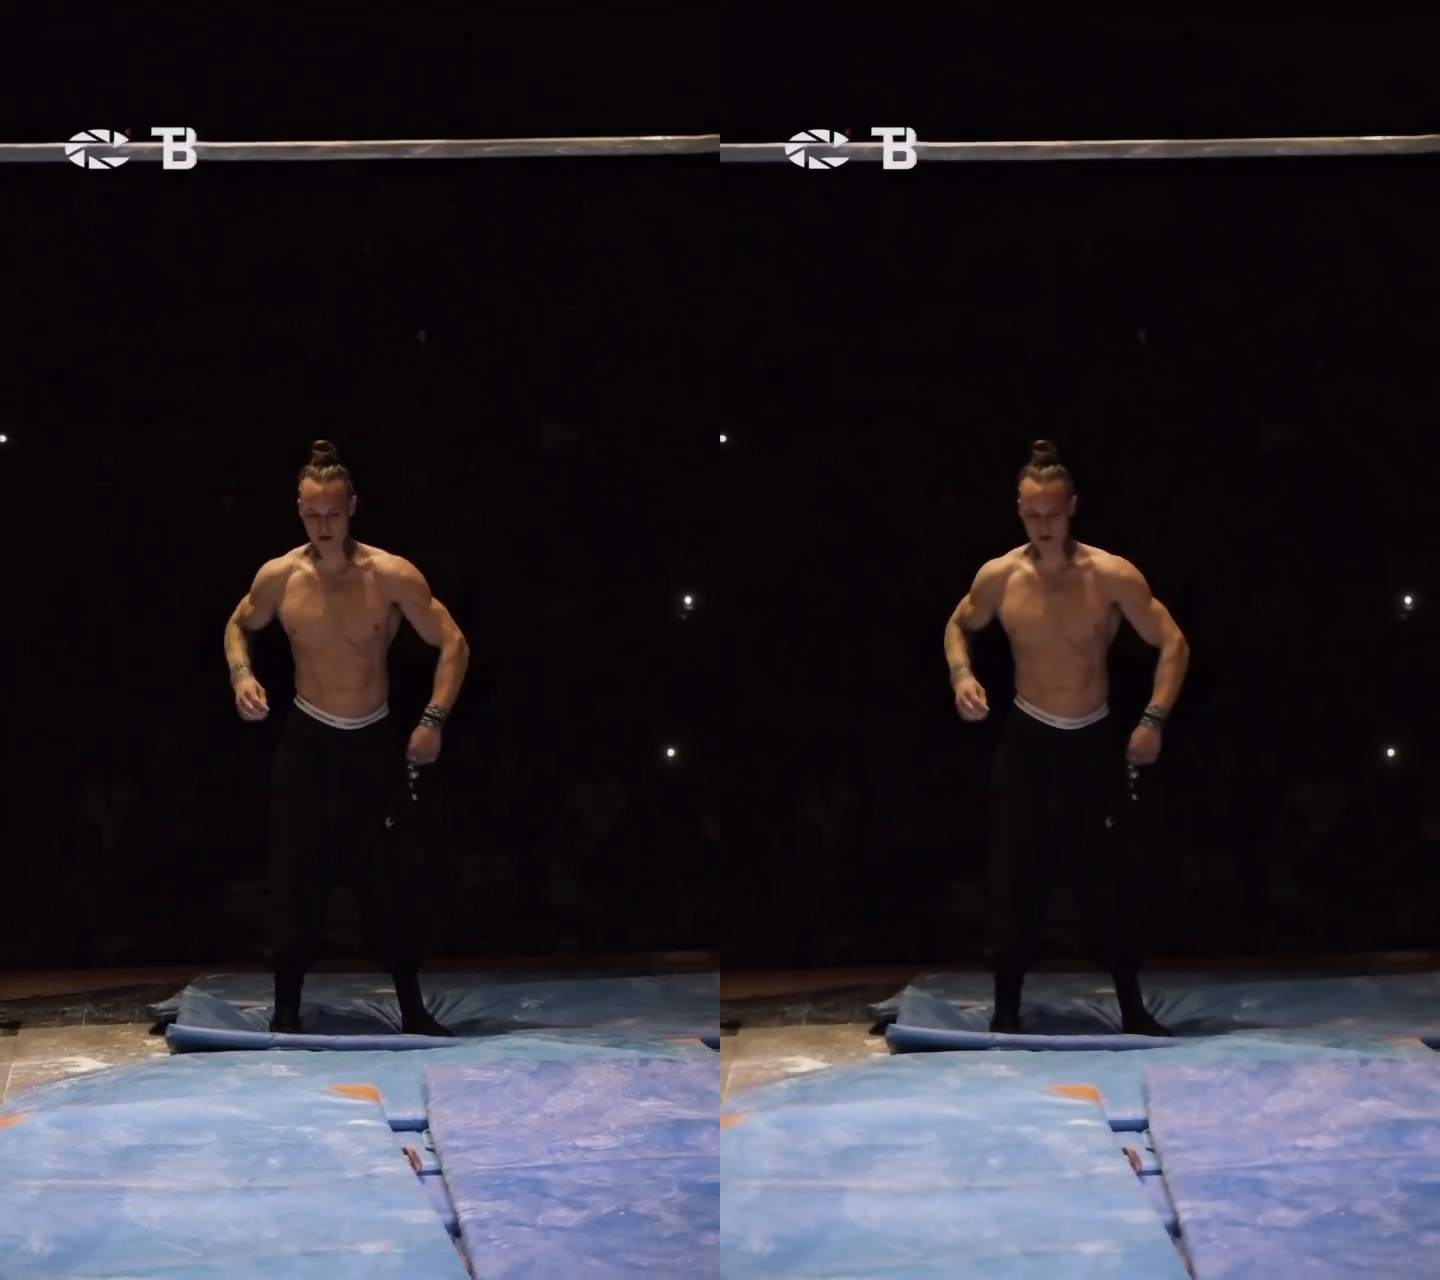

In [10]:
from IPython.display import display
from PIL import Image
import numpy as np
import os

orig_files = sorted([f for f in os.listdir("../frames") if f.endswith(".png")])
nlm_files  = sorted([f for f in os.listdir("../results") if f.endswith("_nlm.png")])

orig_path = f"../frames/{orig_files[20]}"
nlm_path  = f"../results/{nlm_files[0]}"

orig = np.array(Image.open(orig_path).convert("RGB"))
nlm  = np.array(Image.open(nlm_path).convert("RGB"))

concat = np.hstack((orig, nlm))
display(Image.fromarray(concat))
